# Chatbot Reply Generation Model
A chatbot is a software application that uses Artificial Intelligence and generates human-like conversations. The name of our chatbot is EDAIC

**Course No:** CSE4250

**Course Name:** Project & Thesis II

**Supervisor**


*   Md Khairul Hasan



**Team Members**

*   160204107 - Nowshin Rumali
*   170104061 - Amin Ahmed Toshib
*   170104116 - Rejone-E-Rasul Hridoy
*   170104118 - Mehedi Hasan Sami




In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Text Libraries
import nltk 
import string
import re

# Feature Extraction Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Classifier Model libraries
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.neural_network import MLPClassifier

# Performance Matrix libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# other
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

root_path = "/content/drive/MyDrive/CSE/4.1/CSE4100 - Project & Thesis-I/Emotion Detection Chatbot Papers/4.2/"
resource_root_path = "/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Project - Emotion Detection from Twitter Text/"

# Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Dataset

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/CSE/4.2/CSE4214 - Pattern Recognition Lab/Project/text_emotions.csv')
df = pd.read_csv(root_path+'Chatbot Dataset_v12.11.csv',encoding='ISO-8859-1')
df = df.dropna(axis=0)
df

,User,Chatbot,Intent
1,Hello,Hi <HUMAN> how are you?,Greeting
2,Hi,Hello <HUMAN> how are you?,Greeting
3,Hola,Hi <HUMAN> how are you?,Greeting
4,Hi there,Hi <HUMAN> how are you?,Greeting
5,Hya there,Hi <HUMAN> how are you?,Greeting
...,...,...,...
2363,Today I meditated for 30 minutes and I feel am...,I am glad you felt better after meditating,Surprise_Amazed
2364,I broke my foot,I am sorry to hear your foot broke,Health
2365,I broke my foot,I am sorry to hear you broke your foot,Health
2366,My boss gave me priase in front of the group a...,I am glad your work was praised,Happy_Excited_Joy


In [ ]:
df_unduplicate = df.drop_duplicates(keep=False,inplace=False)
df_unduplicate

,User,Chatbot,Intent
1,Hello,Hi <HUMAN> how are you?,Greeting
2,Hi,Hello <HUMAN> how are you?,Greeting
3,Hola,Hi <HUMAN> how are you?,Greeting
4,Hi there,Hi <HUMAN> how are you?,Greeting
5,Hya there,Hi <HUMAN> how are you?,Greeting
...,...,...,...
2363,Today I meditated for 30 minutes and I feel am...,I am glad you felt better after meditating,Surprise_Amazed
2364,I broke my foot,I am sorry to hear your foot broke,Health
2365,I broke my foot,I am sorry to hear you broke your foot,Health
2366,My boss gave me priase in front of the group a...,I am glad your work was praised,Happy_Excited_Joy


In [ ]:
print('Dataset size:',df.shape)
print('Columns are:',df.columns)
Y = df['Intent']

Dataset size: (2064, 3)
Columns are: Index(['User', 'Chatbot', 'Intent'], dtype='object')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064 entries, 1 to 2367
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   User     2064 non-null   object
 1   Chatbot  2064 non-null   object
 2   Intent   2064 non-null   object
dtypes: object(3)
memory usage: 64.5+ KB


## Dataset Emotion Analysis

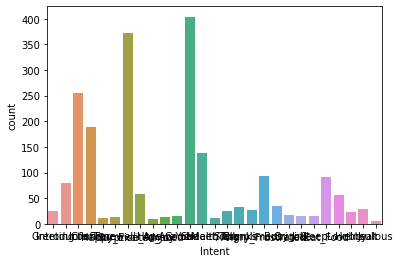

In [ ]:
sns.countplot(x = 'Intent', data = df)

In [ ]:
print('Number of Intents:', len(df['Intent'].unique()))
df['Intent'].unique()

Number of Intents: 27


array(['Greeting', 'Introduction', 'Info', 'Confirm', 'Time', 'Farewell',
       'Happy_Excited_Joy', 'Surprise_Amazed', 'Age', 'HowAreYou', 'Good',
       'Sad', 'Health', 'Meet/Talk', 'Sorry', 'Thanks', 'Compliment',
       'Angry_Frustrated', 'Busy', 'Origin', 'Joke', 'Sleep', 'Eat_Food',
       'Love', 'Hobby', 'Insult', 'Jealous'], dtype=object)

In [ ]:
import collections
counter=collections.Counter(df['Intent'])
counter

Counter({'Age': 10,
         'Angry_Frustrated': 93,
         'Busy': 34,
         'Compliment': 28,
         'Confirm': 190,
         'Eat_Food': 91,
         'Farewell': 13,
         'Good': 15,
         'Greeting': 25,
         'Happy_Excited_Joy': 372,
         'Health': 138,
         'Hobby': 23,
         'HowAreYou': 13,
         'Info': 255,
         'Insult': 29,
         'Introduction': 80,
         'Jealous': 6,
         'Joke': 16,
         'Love': 57,
         'Meet/Talk': 11,
         'Origin': 18,
         'Sad': 404,
         'Sleep': 16,
         'Sorry': 25,
         'Surprise_Amazed': 58,
         'Thanks': 33,
         'Time': 11})

# 2. Pre-processing text data
    1. Remove punctuations
    2. Tokenization - Converting a sentence into list of words
    3. Remove stopwords
    4. Lammetization/stemming - Tranforming any form of a word to its root word

## 2.1 Remove Punctuations

In [ ]:
emojis = pd.read_csv(resource_root_path+'emojis.txt',sep=',',header=None)
emojis_dict = {i:j for i,j in zip(emojis[0],emojis[1])}
pattern = '|'.join(sorted(re.escape(k) for k in emojis_dict))

def replace_emojis(text):
    text = re.sub(pattern,lambda m: emojis_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_emojis(text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am","im":"i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

## 2.2 Tokenization

In [ ]:
def tokenization(text):
    text = text.lower()
    text = re.split('\W+', text)
    return text

## 2.3 Remove Stopwords

In [ ]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['yr', 'year', 'woman', 'man', 'girl','boy','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
              'treatment', 'associated', 'patients', 'may','day', 'case','old','u','n','didnt','ive','ate','feel','keep'
                ,'brother','dad','basic','im'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

## 2.4 Lemmatization

In [ ]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## All in one (Text preprocessing)

In [ ]:
def clean_text(text):
    text = replace_contractions(text)
    text = remove_punct(text)
    text = tokenization(text)
    # text = remove_stopwords(text)
    text = lemmatizer(text)
    return text

# 3. Feature Extraction
    1. Count Vectorizer
    2. TF-IDF (Term Frequency and Inverse Document Frequency)

## 3.1 Count Vectorizer
**CountVectorizer** is a great tool provided by the *scikit-learn* library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).
    
Let us consider a few sample texts from a document:
    
    document 1: Time flies flies like an arrow.
    document 2: Fruit flies like a banana.

    
**CountVectorizer** creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample. 

Vocabulary:  {'time': 6, 'flies': 3, 'like': 5, 'an': 0, 'arrow': 1, 'fruit': 4, 'banana': 2}
Encoded Document is:
[[1 1 0 2 0 1 1]
 [0 0 1 1 1 1 0]]
['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']


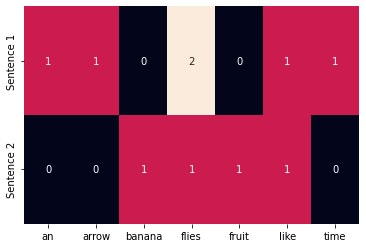

In [ ]:
document = ["Time flies flies like an arrow",
            "Fruit flies like a banana"]
  
# Create a Vectorizer Object
vectorizer = CountVectorizer()
  
vectorizer.fit(document)
  
# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)
  
# Encode the Document
vector = vectorizer.transform(document)
  
# Summarizing the Encoded Texts
print("Encoded Document is:")
print(vector.toarray())

dictionary = sorted(vectorizer.vocabulary_)

print(dictionary)

sns.heatmap(vector.toarray(), annot=True, cbar=False, xticklabels=dictionary,
                                             yticklabels=['Sentence 1','Sentence 2'])

## 3.2 TF-IDF

### 3.2.1 **Term Frequency (TF)**
Term Frequent (**TF**) is a measure of how frequently a term, $t$, appears in a document, $d$:



$$TF_{t,d} = \frac{n_{t,d}}{\text{Total number of terms in document}\ d }$$



$n_{t,d}$ = Number of times term $t$ appears in a document $d$. Thus, each document and term would have its own **TF** value.

Consider these 3 documents:- 

- It was the best of the time.
- it was the worst of Times.
- it is the time of stupidity.

The vocabulary or dictionary of the entire corpus would be:- 

1. it
2. was
3. the 
4. best
5. of
6. time
7. worst
8. is
9. stupidity

Now we will calculate the **TF** values for the **Document 3**. 

Document 3 :- **it is the time of stupidity.**

- Number of words in Document 3 = **6**
- TF for the word **‘the’** = (number of times **‘the’** appears in Document 3) / (number of terms in Document 3) = **1/6**

Likewise:- 

- TF(**'it'**) = 1/6
- TF(**'was'**) = 0/6 = 0
- TF(**'the'**) = 1/6 
- TF(**'best'**) = 0/6 = 0
- TF(**'of'**) = 1/6 
- TF(**'time'**) = 1/6
- TF(**'worst'**) = 0/6 = 0
- TF(**'is'**) = 1/6
- TF(**'stupidity'**) = 1/6

We can calculate all the term frequencies for all the terms of all the documents in this manner:-

|    Term   | Document#1 | Document#2 | Document#3 | TF (Document#1) | TF (Document#2) | TF (Document#3) |
|:---------:|:----------:|:----------:|:----------:|:---------------:|:---------------:|:---------------:|
|     it    |      1     |      1     |      1     |       1/7       |       1/6       |       1/6       |
|    was    |      1     |      1     |      0     |       1/7       |       1/6       |        0        |
|    the    |      2     |      1     |      1     |       2/7       |       1/6       |       1/6       |
|    best   |      1     |      0     |      0     |       1/7       |        0        |        0        |
|     of    |      1     |      1     |      1     |       1/7       |       1/6       |       1/6       |
|    time   |      1     |      1     |      1     |       1/7       |       1/6       |       1/6       |
|   worst   |      0     |      1     |      0     |        0        |       1/6       |        0        |
|    is     |      0     |      0     |      1     |        0        |        0        |       1/6       |
| stupidity |      0     |      0     |      1     |        0        |        0        |       1/6       |







### 3.2.2 **Inverse Document Frequency (IDF)**

IDF is a measure of how important a term is. We need the IDF value because computing just the **TF alone is not sufficient** to understand the importance of words:



$$IDF_{t} = log \ (\frac{\text{Total Number of Documents}}{\text{The Number of Documents with Term $t$}})$$



A problem with scoring word frequency is that highly frequent words **(‘is’, ‘the’, ‘a’ etc)** start to dominate in the document (e.g. larger score), but may not contain as much **“useful information”** to the model comapre to the rarer but **domain specific words**.


One approach is to rescale the frequency of words by **how often they appear in all documents**, so that the scores for frequent words like “the” that are also frequent **across all documents are penalized**.

This approach to scoring is called Term Frequency – Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency:** is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency:** is a scoring of how rare the word is across documents.

**Thus the idf of a rare term is high, whereas the idf of a frequent term is likely to be low.**

We can calculate the IDF values for **Document 3**:

Document 3 :- **it is the time of stupidity.**

IDF(**‘it’**) =  log(total number of documents/number of documents containing the word **‘it’**) = log(3/3) = log(1) = 0

IDF(**‘stupidity’**) =  log(total number of documents/number of documents containing the word **‘stupidity’**) = log(3/1) = log(3) = 0.48

We can calculate the IDF values for each word like this. Thus, the IDF values for the entire vocabulary would be:

|    Term   | Document#1 | Document#2 | Document#3 |  IDF |
|:---------:|:----------:|:----------:|:----------:|:----:|
|     it    |      1     |      1     |      1     | 0.00 |
|    was    |      1     |      1     |      0     | 0.18 |
|    the    |      2     |      1     |      1     | 0.00 |
|    best   |      1     |      0     |      0     | 0.48 |
|     of    |      1     |      1     |      1     | 0.00 |
|    time   |      1     |      1     |      1     | 0.00 |
|   worst   |      0     |      1     |      0     | 0.48 |
|    is     |      0     |      0     |      1     | 0.48 |
| stupidity |      0     |      0     |      1     | 0.48 |

\

We can now compute the TF-IDF score for each word in the corpus. Words with a higher score are more important, and those with a lower score are less important:

$$(TF-IDF)_{t,d} = TF_{t,d} * IDF_{t}$$


You can find the overall summary in the following figure.

<div align="center">
<img src="https://drive.google.com/uc?id=1Xw5RlK_RxYtZEQtpFNaePXnJNyQmLcn1" width="680" height="230">
</div>



We can now calculate the TF-IDF score for every word in **Document 3**:

Document 3 :- **it is the time of stupidity.**

TF-IDF(‘it’, Document 3) = TF(‘it’, Document 3) * IDF(‘it’) = 1/6 * 0 = 0

Likewise:- 

- TF(**'it'**) = (1/6) * 0 = 0
- TF(**'is'**) = (1/6) * 0.48 = 0.08
- TF(**'the'**) = (1/6) * 0 = 0
- TF(**'best'**) = (0/6) * 0.48 = 0
- TF(**'time'**) = (1/6) * 0 = 0
- TF(**'of'**) = (1/6) * 0 = 0
- TF(**'stupidity'**) = (1/6) * 0.48 = 0.08

Similarly, we can calculate the TF-IDF scores for all the words with respect to all the documents.

- First, notice how if there is a very common
word that occurs in all documents (i.e., n = N), IDF(w) is 0 and the TF­IDF score is 0, thereby
completely penalizing that term. 
- Second, if a term occurs very rarely, perhaps in only one document,
the IDF will be the maximum possible value, log N


[[0.42519636 0.42519636 0.         0.60506143 0.         0.30253071
  0.42519636]
 [0.         0.         0.57615236 0.40993715 0.57615236 0.40993715
  0.        ]]
{'time': 6, 'flies': 3, 'like': 5, 'an': 0, 'arrow': 1, 'fruit': 4, 'banana': 2}
['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']


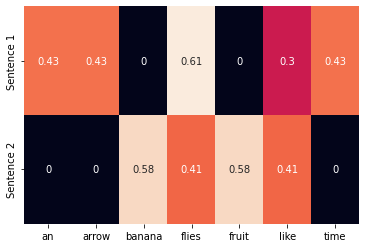

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

document = ['Time flies flies like an arrow.',
          'Fruit flies like a banana.']

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(document).toarray()

print (tfidf)

print (tfidf_vectorizer.vocabulary_)

dictionary = sorted(tfidf_vectorizer.vocabulary_)

print(dictionary)

sns.heatmap(tfidf, annot=True, cbar=False, xticklabels=dictionary,
                                           yticklabels=['Sentence 1','Sentence 2'])

### Applying Feature Extraction in tweet dataset

#### Train Test Split (75-25)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['User'], df['Intent'],test_size=0.25, random_state = 32)

In [ ]:
countVectorizer1 = CountVectorizer(analyzer=clean_text)
countVector1 = countVectorizer1.fit_transform(X_train)

countVector2 = countVectorizer1.transform(X_test)

tfidf_transformer_xtrain = TfidfTransformer()
x_train = tfidf_transformer_xtrain.fit_transform(countVector1)

tfidf_transformer_xtest = TfidfTransformer()
x_test = tfidf_transformer_xtest.fit_transform(countVector2)

# 4. Models
1. Support Vector Machine (SVM)
2. Logistic Regression
3. Random Forest Classifier
4. XGBoost Classifier
5. Multinomial Naive Bayes
6. Decision Tree Classifier
7. MultiLayer Perception (MLP)



**Performance Matrix :**
1.   **Accuracy** = $\frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}$
2.   **Precision** = $\frac{\text{TP}}{\text{TP+FP}}$ 
3.   **Recall** = $\frac{\text{TP}}{\text{TP+FN}}$ 
4.   **F1-score** = $\frac{\text{2*Precision*Recall}}{\text{Precision+Recall}}$ 

## 4.1 Support Vector Machine (SVM)

In [ ]:
svm = SGDClassifier()
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_test, y_pred, average='macro')
svm_recal = recall_score(y_test, y_pred, average='macro')
svm_cm = confusion_matrix(y_test,y_pred)
svm_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(svm_acc*100))
print('Precision:', '{0:.3f}'.format(svm_prec*100))
print('Recall:', '{0:.3f}'.format(svm_recal*100))
print('F1-score:', '{0:.3f}'.format(svm_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 71.705
Precision: 65.162
Recall: 63.266
F1-score: 61.527
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.75      0.48      0.59        25
             Busy       0.75      0.60      0.67        10
       Compliment       0.38      0.75      0.50         4
          Confirm       0.65      0.60      0.62        52
         Eat_Food       0.65      0.68      0.67        19
         Farewell       0.00      0.00      0.00         2
             Good       0.67      0.50      0.57         4
         Greeting       0.75      0.75      0.75         4
Happy_Excited_Joy       0.84      0.87      0.85       104
           Health       0.85      0.76      0.80        37
            Hobby       1.00      0.43      0.60         7
        HowAreYou       1.00      0.75      0.86         4
             Info       0.66      0.59      0.62        68
           Insult       0.71      0.71      0.7

### 4.1.1 Confusion Matrix

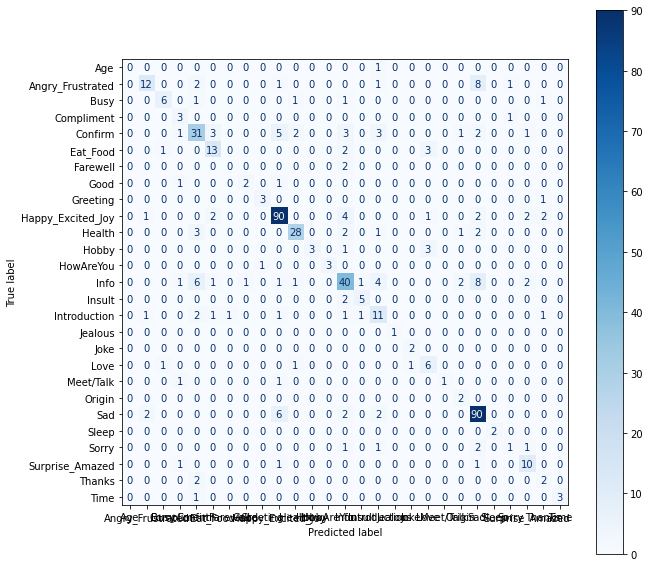

In [ ]:
cm_display_svm = ConfusionMatrixDisplay(svm_cm, display_labels=svm.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
ax.set_xticklabels(svm.classes_, rotation='vertical', fontsize=10)
cm_display_svm.plot(ax=ax,cmap='Blues')

## 4.2 Logistic Regression

In [ ]:
logisticRegr = LogisticRegression()

logisticRegr.fit(x_train, y_train)

y_pred = logisticRegr.predict(x_test)

lr_acc = accuracy_score(y_pred, y_test)
lr_prec = precision_score(y_test, y_pred, average='macro')
lr_recal = recall_score(y_test, y_pred, average='macro')
lr_cm = confusion_matrix(y_test,y_pred)
lr_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(lr_acc*100))
print('Precision:', '{0:.3f}'.format(lr_prec*100))
print('Recall:', '{0:.3f}'.format(lr_recal*100))
print('F1-score:', '{0:.3f}'.format(lr_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 56.008
Precision: 43.667
Recall: 28.879
F1-score: 31.400
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.75      0.12      0.21        25
             Busy       1.00      0.30      0.46        10
       Compliment       0.00      0.00      0.00         4
          Confirm       0.49      0.52      0.50        52
         Eat_Food       0.67      0.32      0.43        19
         Farewell       0.00      0.00      0.00         2
             Good       0.00      0.00      0.00         4
         Greeting       0.50      0.25      0.33         4
Happy_Excited_Joy       0.59      0.83      0.69       104
           Health       0.94      0.43      0.59        37
            Hobby       1.00      0.14      0.25         7
        HowAreYou       0.00      0.00      0.00         4
             Info       0.52      0.50      0.51        68
           Insult       1.00      0.57      0.7

### 4.2.1 Confusion Matrix

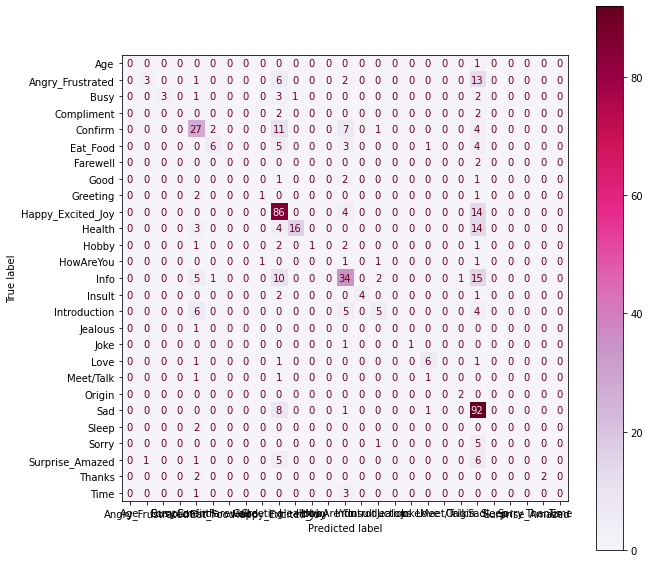

In [ ]:
cm_display_lr = ConfusionMatrixDisplay(lr_cm, display_labels=logisticRegr.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_lr.plot(ax=ax,cmap='PuRd')

## 4.3 Random Forest Classifier

random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

**Hyperparametes:**

**Increasing the predictive power**

Firstly, there is the **n_estimators** hyperparameter, which is just the number of trees the algorithm builds before taking the maximum voting or taking the averages of predictions. In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation.

Another important hyperparameter is **max_features**, which is the maximum number of features random forest considers to split a node. Sklearn provides several options, all described in the documentation.

The last important hyperparameter is **min_sample_leaf**. This determines the minimum number of leafs required to split an internal node.

[click for more](https://builtin.com/data-science/random-forest-algorithm)

In [ ]:
rfc = RandomForestClassifier(n_estimators=1, random_state=0)

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

rfc_acc = accuracy_score(y_pred, y_test)
rfc_prec = precision_score(y_test, y_pred, average='macro')
rfc_recal = recall_score(y_test, y_pred, average='macro')
rfc_cm = confusion_matrix(y_test,y_pred)
rfc_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(rfc_acc*100))
print('Precision:', '{0:.3f}'.format(rfc_prec*100))
print('Recall:', '{0:.3f}'.format(rfc_recal*100))
print('F1-score:', '{0:.3f}'.format(rfc_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 48.450
Precision: 44.200
Recall: 40.760
F1-score: 38.363
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.50      0.36      0.42        25
             Busy       0.75      0.30      0.43        10
       Compliment       0.00      0.00      0.00         4
          Confirm       0.38      0.38      0.38        52
         Eat_Food       0.56      0.47      0.51        19
         Farewell       0.00      0.00      0.00         2
             Good       0.50      0.25      0.33         4
         Greeting       0.11      0.50      0.18         4
Happy_Excited_Joy       0.55      0.54      0.55       104
           Health       0.46      0.46      0.46        37
            Hobby       1.00      0.14      0.25         7
        HowAreYou       0.00      0.00      0.00         4
             Info       0.53      0.46      0.49        68
           Insult       0.44      0.57      0.5

### 4.3.1 Confusion Matrix

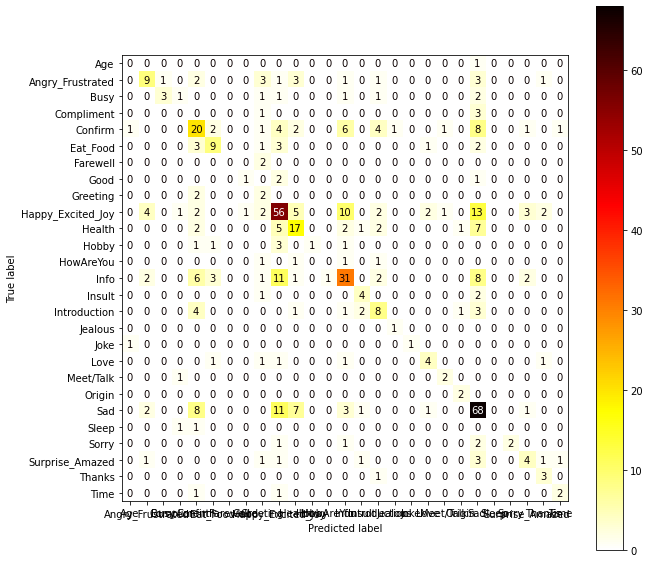

In [ ]:
cm_display_rfc = ConfusionMatrixDisplay(rfc_cm, display_labels=rfc.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_rfc.plot(ax=ax,cmap='hot_r')

## 4.4 XGBoost Classifier

**XGBoost** is a decision-tree-based ensemble Machine Learning algorithm that uses a *gradient boosting framework*. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.


**Why does XGBoost perform so well?**

> XGBoost and Gradient Boosting Machines (GBMs) are both ensemble tree methods that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. However, XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements.


[Click for more details](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [ ]:
xgbc = XGBClassifier(max_depth=16, n_estimators=1000,nthread = 6)
xgbc.fit(x_train,y_train)
y_pred = xgbc.predict(x_test)

xgbc_acc = accuracy_score(y_pred, y_test)
xgbc_prec = precision_score(y_test, y_pred, average='macro')
xgbc_recal = recall_score(y_test, y_pred, average='macro')
xgbc_cm = confusion_matrix(y_test,y_pred)
xgbc_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(xgbc_acc*100))
print('Precision:', '{0:.3f}'.format(xgbc_prec*100))
print('Recall:', '{0:.3f}'.format(xgbc_recal*100))
print('F1-score:', '{0:.3f}'.format(xgbc_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 58.721
Precision: 48.477
Recall: 49.885
F1-score: 45.875
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.56      0.40      0.47        25
             Busy       0.80      0.40      0.53        10
       Compliment       0.25      0.75      0.38         4
          Confirm       0.51      0.50      0.50        52
         Eat_Food       0.50      0.53      0.51        19
         Farewell       0.25      1.00      0.40         2
             Good       0.50      0.50      0.50         4
         Greeting       0.75      0.75      0.75         4
Happy_Excited_Joy       0.70      0.74      0.72       104
           Health       0.63      0.46      0.53        37
            Hobby       0.50      0.14      0.22         7
        HowAreYou       0.50      0.25      0.33         4
             Info       0.62      0.54      0.58        68
           Insult       0.20      0.14      0.1

### 4.4.1 Confusion Matrix

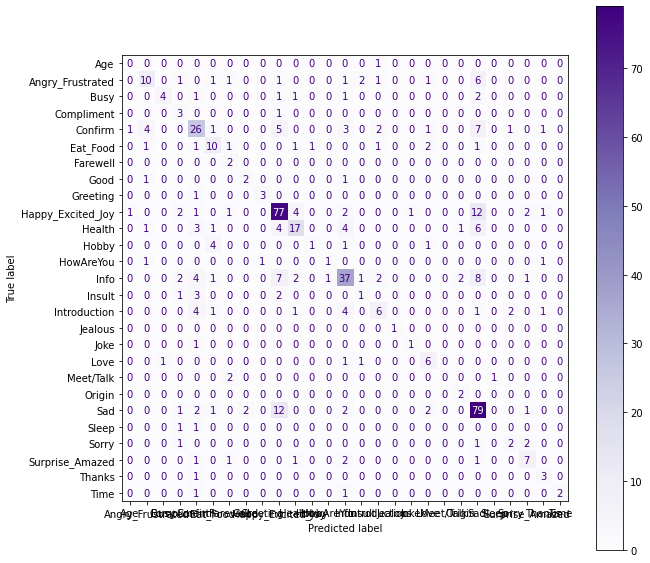

In [ ]:
cm_display_xgbc = ConfusionMatrixDisplay(xgbc_cm, display_labels=xgbc.classes_)
_, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_xgbc.plot(ax=ax,cmap='Purples')

## 4.5 Multinomial Naive Bayes Classifier

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)

y_pred = mnb.predict(x_test)

mnb_acc = accuracy_score(y_pred, y_test)
mnb_prec = precision_score(y_test, y_pred, average='macro')
mnb_recal = recall_score(y_test, y_pred, average='macro')
mnb_cm = confusion_matrix(y_test,y_pred)
mnb_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(mnb_acc*100))
print('Precision:', '{0:.3f}'.format(mnb_prec*100))
print('Recall:', '{0:.3f}'.format(mnb_recal*100))
print('F1-score:', '{0:.3f}'.format(mnb_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 44.186
Precision: 10.670
Recall: 9.334
F1-score: 7.555
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.00      0.00      0.00        25
             Busy       0.00      0.00      0.00        10
       Compliment       0.00      0.00      0.00         4
          Confirm       0.54      0.27      0.36        52
         Eat_Food       0.00      0.00      0.00        19
         Farewell       0.00      0.00      0.00         2
             Good       0.00      0.00      0.00         4
         Greeting       0.00      0.00      0.00         4
Happy_Excited_Joy       0.51      0.84      0.64       104
           Health       1.00      0.03      0.05        37
            Hobby       0.00      0.00      0.00         7
        HowAreYou       0.00      0.00      0.00         4
             Info       0.45      0.46      0.45        68
           Insult       0.00      0.00      0.00 

### 4.5.1 Confusion Matrix

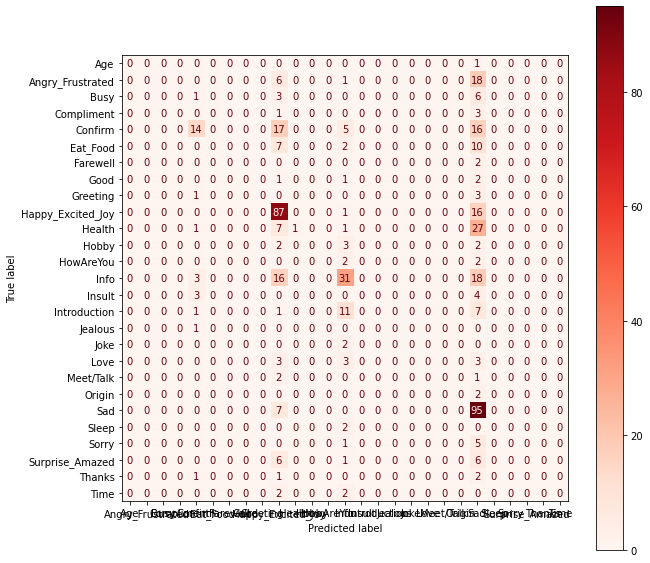

In [ ]:
cm_display_mnb = ConfusionMatrixDisplay(mnb_cm, display_labels=mnb.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_mnb.plot(ax=ax,cmap='Reds')

## 4.6 Decision Tree Classifier

In [ ]:
dt = tree.DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)


dt_acc = accuracy_score(y_pred, y_test)
dt_prec = precision_score(y_test, y_pred, average='macro')
dt_recal = recall_score(y_test, y_pred, average='macro')
dt_cm = confusion_matrix(y_test,y_pred)
dt_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(dt_acc*100))
print('Precision:', '{0:.3f}'.format(dt_prec*100))
print('Recall:', '{0:.3f}'.format(dt_recal*100))
print('F1-score:', '{0:.3f}'.format(dt_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 53.682
Precision: 54.229
Recall: 47.639
F1-score: 48.513
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.75      0.36      0.49        25
             Busy       0.80      0.40      0.53        10
       Compliment       0.75      0.75      0.75         4
          Confirm       0.32      0.38      0.35        52
         Eat_Food       0.50      0.37      0.42        19
         Farewell       0.00      0.00      0.00         2
             Good       0.33      0.25      0.29         4
         Greeting       0.67      0.50      0.57         4
Happy_Excited_Joy       0.61      0.68      0.65       104
           Health       0.55      0.49      0.51        37
            Hobby       0.80      0.57      0.67         7
        HowAreYou       0.00      0.00      0.00         4
             Info       0.69      0.54      0.61        68
           Insult       1.00      0.57      0.7

### 4.6.1 Confusion Matrix

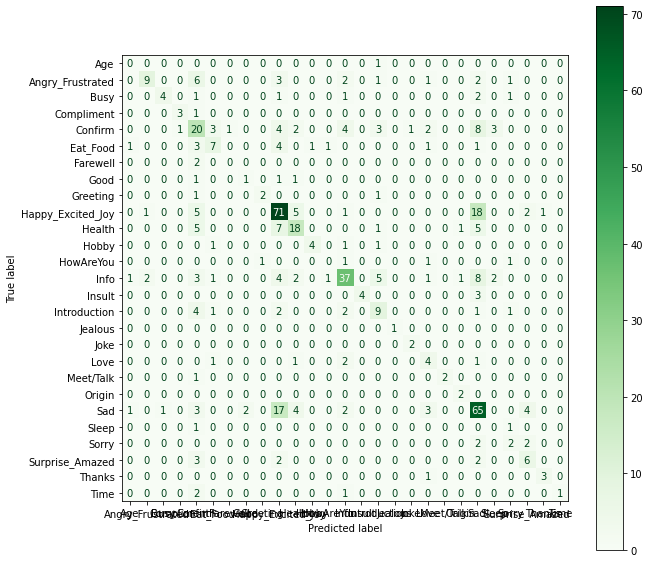

In [ ]:
cm_display_dt = ConfusionMatrixDisplay(dt_cm, display_labels=dt.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_dt.plot(ax=ax,cmap='Greens')

# 4.7 Multi Layer Perception

In [ ]:
mlp = MLPClassifier(random_state=5, max_iter=300)

mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_test)

mlp_acc = accuracy_score(y_pred, y_test)
mlp_prec = precision_score(y_test, y_pred, average='macro')
mlp_recal = recall_score(y_test, y_pred, average='macro')
mlp_cm = confusion_matrix(y_test,y_pred)
mlp_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(mlp_acc*100))
print('Precision:', '{0:.3f}'.format(mlp_prec*100))
print('Recall:', '{0:.3f}'.format(mlp_recal*100))
print('F1-score:', '{0:.3f}'.format(mlp_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 70.930
Precision: 65.781
Recall: 61.862
F1-score: 61.241
                   precision    recall  f1-score   support

              Age       0.00      0.00      0.00         1
 Angry_Frustrated       0.81      0.52      0.63        25
             Busy       0.86      0.60      0.71        10
       Compliment       0.50      0.75      0.60         4
          Confirm       0.62      0.56      0.59        52
         Eat_Food       0.68      0.68      0.68        19
         Farewell       0.00      0.00      0.00         2
             Good       0.40      0.50      0.44         4
         Greeting       0.75      0.75      0.75         4
Happy_Excited_Joy       0.81      0.83      0.82       104
           Health       0.82      0.76      0.79        37
            Hobby       0.75      0.43      0.55         7
        HowAreYou       1.00      0.50      0.67         4
             Info       0.66      0.63      0.65        68
           Insult       0.83      0.71      0.7

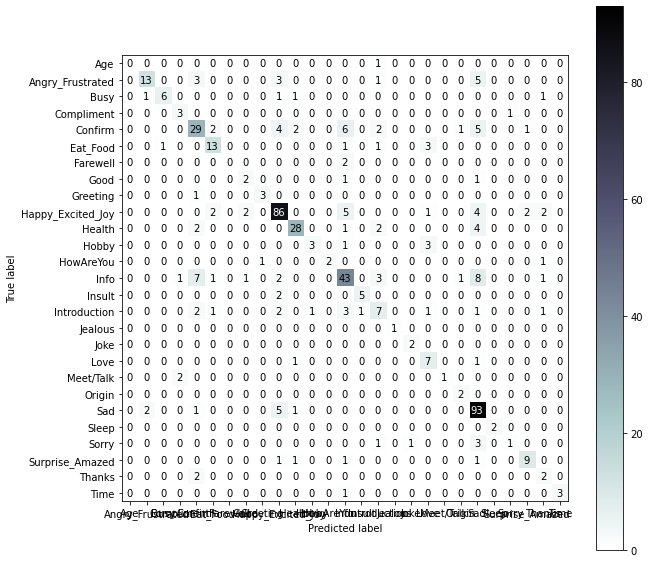

In [ ]:
cm_display_mlp = ConfusionMatrixDisplay(mlp_cm, display_labels=mlp.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display_mlp.plot(ax=ax,cmap='bone_r')

# 5. Summary Visualization

In [ ]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))
        
    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))
        
    return per_emotion_precision, per_emotion_recall

## 5.1 - Precision of all models

In [ ]:
svm_per_prec,svm_per_recall = get_prec_recall_per_emotion(svm_cm)
lr_per_prec,lr_per_recall = get_prec_recall_per_emotion(lr_cm)
rfc_per_prec,rfc_per_recall = get_prec_recall_per_emotion(rfc_cm)
xgbc_per_prec,xgbc_per_recall = get_prec_recall_per_emotion(xgbc_cm)
mnb_per_prec,mnb_per_recall = get_prec_recall_per_emotion(mnb_cm)
dt_per_prec,dt_per_recall = get_prec_recall_per_emotion(dt_cm)
mlp_per_prec,mlp_per_recall = get_prec_recall_per_emotion(mlp_cm)

per_precision_list = pd.DataFrame({'Support vector Machine' : svm_per_prec,
                                'Logistic Regression' : lr_per_prec,
                                'Random Forest' : rfc_per_prec,
                                'XGBoost' : xgbc_per_prec,
                                'Naive Bayes' : mnb_per_prec,
                                'Decision Tree' : dt_per_prec,
                                'Multi Layer Perceptron' : mlp_per_prec}, 
                                index=svm.classes_)
per_precision_list

,Support vector Machine,Logistic Regression,Random Forest,XGBoost,Naive Bayes,Decision Tree,Multi Layer Perceptron
Age,NaN,NaN,0.000,0.000,NaN,0.000,NaN
Angry_Frustrated,68.421,75.000,50.000,55.556,NaN,63.636,81.250
Busy,66.667,100.000,75.000,80.000,NaN,42.857,85.714
Compliment,42.857,NaN,0.000,25.000,NaN,60.000,50.000
Confirm,65.957,49.091,38.462,50.980,53.846,37.288,61.702
Eat_Food,65.000,66.667,56.250,50.000,NaN,50.000,68.421
Farewell,0.000,NaN,NaN,25.000,NaN,0.000,NaN
Good,100.000,NaN,50.000,50.000,NaN,33.333,40.000
Greeting,75.000,50.000,11.111,75.000,NaN,66.667,75.000
Happy_Excited_Joy,84.615,58.503,55.446,70.000,51.479,61.765,81.132


In [ ]:
print(len(set(y_test)))
import collections
counter=collections.Counter(y_test)
counter

27


Counter({'Age': 1,
         'Angry_Frustrated': 25,
         'Busy': 10,
         'Compliment': 4,
         'Confirm': 52,
         'Eat_Food': 19,
         'Farewell': 2,
         'Good': 4,
         'Greeting': 4,
         'Happy_Excited_Joy': 104,
         'Health': 37,
         'Hobby': 7,
         'HowAreYou': 4,
         'Info': 68,
         'Insult': 7,
         'Introduction': 20,
         'Jealous': 1,
         'Joke': 2,
         'Love': 9,
         'Meet/Talk': 3,
         'Origin': 2,
         'Sad': 102,
         'Sleep': 2,
         'Sorry': 6,
         'Surprise_Amazed': 13,
         'Thanks': 4,
         'Time': 4})

## 5.2 - Recall of all models

In [ ]:
per_recall_list = pd.DataFrame({'Support vector Machine' : svm_per_recall,
                                'Logistic Regression' : lr_per_recall,
                                'Random Forest' : rfc_per_recall,
                                'XGBoost' : xgbc_per_recall,
                                'Naive Bayes' : mnb_per_recall,
                                'Decision Tree' : dt_per_recall,
                                'Multi Layer Perceptron' : mlp_per_recall}, 
                                index=svm.classes_)
per_recall_list

,Support vector Machine,Logistic Regression,Random Forest,XGBoost,Naive Bayes,Decision Tree,Multi Layer Perceptron
Age,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Angry_Frustrated,52.000,12.000,36.000,40.000,0.000,28.000,52.000
Busy,60.000,30.000,30.000,40.000,0.000,30.000,60.000
Compliment,75.000,0.000,0.000,75.000,0.000,75.000,75.000
Confirm,59.615,51.923,38.462,50.000,26.923,42.308,55.769
Eat_Food,68.421,31.579,47.368,52.632,0.000,31.579,68.421
Farewell,0.000,0.000,0.000,100.000,0.000,0.000,0.000
Good,50.000,0.000,25.000,50.000,0.000,25.000,50.000
Greeting,75.000,25.000,50.000,75.000,0.000,50.000,75.000
Happy_Excited_Joy,84.615,82.692,53.846,74.038,83.654,60.577,82.692


## 5.3 Accuracy Visualization for all models

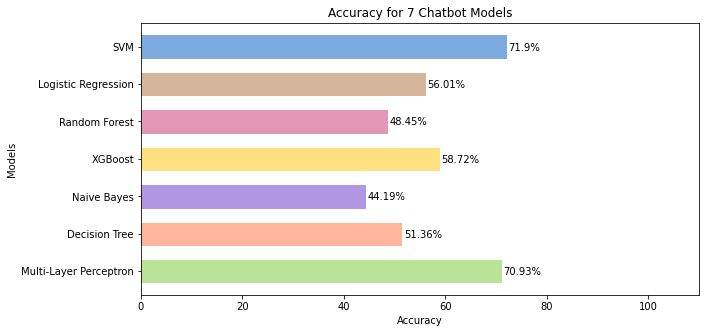

In [ ]:
algorithms = ['Multi-Layer Perceptron','Decision Tree','Naive Bayes','XGBoost','Random Forest','Logistic Regression','SVM']
algorithm_acc = [mlp_acc*100, dt_acc*100, mnb_acc*100, xgbc_acc*100, rfc_acc*100, lr_acc*100, svm_acc*100]
# Figure Size
fig = plt.figure(figsize =(10, 5))
bar_list = plt.barh(algorithms, algorithm_acc,height = 0.6,color='black')
bar_list[6].set_color('#7CAADE')
bar_list[5].set_color('#D5B59C')
bar_list[4].set_color('#E396B6')
bar_list[3].set_color('#FFDF80')
bar_list[2].set_color('#B096E3')
bar_list[1].set_color('#FFB49C')
bar_list[0].set_color('#B9E396')
plt.xlabel('Accuracy',color='black')
plt.ylabel('Models',color='black')
plt.title('Accuracy for 7 Chatbot Models')
plt.xlim(0,110)

for i, v in enumerate(algorithm_acc):
    plt.text(v + 0.5, i - 0.1, str(round(v,2))+'%', color='black',fontsize=10)
plt.savefig(root_path+'/Models/Chatbot Accuracy_7 models.jpg')
plt.show()

## Save all Models in Disk

In [ ]:
with open(root_path+'/Models/Chatbot Models_7 models_final.pkl', 'wb') as f:
    pickle.dump([svm, logisticRegr, rfc, xgbc, mnb, dt, mlp], f)

## Load all Model from Disk

In [ ]:
if os.path.isfile(root_path+'/Models/Chatbot Models_7 models_final.pkl'):
    # Getting back the objects:
    with open(root_path+'/Models/Chatbot Models_7 models_final.pkl','rb') as f:  # Python 3: open(..., 'rb')
        svm, logisticRegr, rfc, xgbc, mnb, dt, mlp = pickle.load(f)
        print('File Loaded Successfully')
else:
    print('File not Found')

File Loaded Successfully


# 6. Prediction

In [ ]:
import random
def response_generate(text, intent_name):
    reply = respond(text, intent_name)

    return reply

In [ ]:
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)

    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    return round((1-cosine),2)

In [ ]:

def respond(text, intent_name):
    maximum = float('-inf')
    response = ""
    closest = ""
    replies = {}
    list_sim, list_replies = [],[]
    dataset = df[df['Intent']==intent_name]
    for i in dataset.iterrows():
        sim = cosine_distance_countvectorizer_method(text, i[1]['User'])
        list_sim.append(sim)
        list_replies.append(i[1]['Chatbot'])

    for i in range(len(list_sim)):
        if list_sim[i] in replies:
            replies[list_sim[i]].append(list_replies[i])
        else:
            replies[list_sim[i]] = list()
            replies[list_sim[i]].append(list_replies[i])
    d1 = sorted(replies.items(), key = lambda pair:pair[0],reverse=True)
    return d1[0][1][random.randint(0,len(d1[0][1])-1)]

### Implementing Ensemble Learning with weighted voting

In [ ]:
accuracies = np.array([svm_acc, lr_acc, rfc_acc, xgbc_acc, mnb_acc, dt_acc, mlp_acc])
norm_accuracy = accuracies - min(accuracies)
model_weight = norm_accuracy / sum(norm_accuracy)  #SVM, Logistic Regression, RF, XGB, NB, DT, MLP
Intents = df['Intent'].unique()
def extract_best_intent(list_intent_pred):
    intent_scores = {}
    for intent in Intents:
        intent_scores[intent] = 0.0   
    for i in range(len(list_intent_pred)):
        intent_scores[list_intent_pred[i]] += model_weight[i]
    si = sorted(intent_scores.items(), key = lambda pair:pair[1],reverse=True)[:7]
    return si[0][0],si

Weight of Models

In [ ]:
accuracies = np.array([svm_acc, lr_acc, rfc_acc, xgbc_acc, mnb_acc, dt_acc, mlp_acc])
norm_accuracy = accuracies - min(accuracies)
model_weight = norm_accuracy / sum(norm_accuracy)
model_weight

array([0.29515419, 0.12995595, 0.04185022, 0.15969163, 0.        ,
       0.07929515, 0.29405286])

In [ ]:
while True:
    input_str = input("What's in your mind: ")
    if input_str == 'nothing':
        break
        
    processed_text = tfidf_transformer_xtest.fit_transform(countVectorizer1.transform([input_str]))
    print('Intent using SVM: ',end = '')
    svm_intent = svm.predict(processed_text)[0]
    lr_intent = logisticRegr.predict(processed_text)[0]
    dt_intent = dt.predict(processed_text)[0]
    mnb_intent = mnb.predict(processed_text)[0]
    xgbc_intent = xgbc.predict(processed_text)[0]
    rfc_intent = rfc.predict(processed_text)[0]
    mlp_intent = mlp.predict(processed_text)[0]
    print(svm_intent)
    
    print('Intent using Logistic Regression: ',end = '')
    print(logisticRegr.predict(processed_text))
    print('Intent using Decision Tree: ',end = '')
    print(dt.predict(processed_text))
    print('Intent using Naive Bayes: ',end = '')
    print(mnb.predict(processed_text))
    print('Intent using XGBoost: ',end = '')
    print(xgbc.predict(processed_text))
    print('Intent using Random Forest: ',end = '')
    print(rfc.predict(processed_text))
    print('Intent using Multi Layer Perceptron: ',end = '')
    print(mlp.predict(processed_text))


    # generating reply
    list_intent = [svm_intent, lr_intent, rfc_intent, xgbc_intent, mnb_intent, dt_intent, mlp_intent]
    best_intent, si = extract_best_intent(list_intent)
    print(si)
    print('Best Intent:',best_intent)
    print('EDAIC: ',response_generate(input_str, best_intent))
    print()

Intent using SVM: Sad
Intent using Logistic Regression: ['Health']
Intent using Decision Tree: ['Busy']
Intent using Naive Bayes: ['Sad']
Intent using XGBoost: ['Busy']
Intent using Random Forest: ['Health']
Intent using Multi Layer Perceptron: ['Sad']
[('Sad', 0.5892070484581498), ('Busy', 0.23898678414096913), ('Health', 0.17180616740088112), ('Greeting', 0.0), ('Introduction', 0.0), ('Info', 0.0), ('Confirm', 0.0)]
Best Intent: Sad
EDAIC:  Things will be better one day.

Intent using SVM: Sad
Intent using Logistic Regression: ['Health']
Intent using Decision Tree: ['Busy']
Intent using Naive Bayes: ['Sad']
Intent using XGBoost: ['Busy']
Intent using Random Forest: ['Health']
Intent using Multi Layer Perceptron: ['Sad']
[('Sad', 0.5892070484581498), ('Busy', 0.23898678414096913), ('Health', 0.17180616740088112), ('Greeting', 0.0), ('Introduction', 0.0), ('Info', 0.0), ('Confirm', 0.0)]
Best Intent: Sad
EDAIC:  Things will be better one day.

Intent using SVM: Hobby
Intent using Logis